Notebook to review the collected data, test augmentations, and apply the DataGenerator to see how it performs. 

In [1]:
import os
import glob
import sys
import time
import itertools
import json
import numpy as np

# Root directory of the project
FILE_DIR = os.path.dirname(os.path.abspath("__file__"))
ROOT_DIR = os.path.join(FILE_DIR, "..", "..")
sys.path.append(ROOT_DIR)

from mrcnn import utils
from mrcnn import visualize
from mrcnn import utils
from mrcnn.config import Config
import mrcnn.model as modellib
from mrcnn.model import log

import imgaug
from balloon import BalloonDataset

## Initialize Model and Dataset Configs

In [2]:
class BalloonConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "balloon"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + balloon

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 50

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    
    # see REMARK in the description
    USE_MINI_MASK = False
    
    # TF2 feature - now you can run the model interactively 
    RUN_EAGERLY = False
        
config = BalloonConfig()
# config.display()

## Initialize the Dataset

In [3]:
BALLOON_DIR = os.path.join(ROOT_DIR, 'data', 'balloon')

train_ds = BalloonDataset()
val_ds = BalloonDataset()

# load data
train_ds.load_balloon(BALLOON_DIR, 'train')
val_ds.load_balloon(BALLOON_DIR, 'val')

# transform data into container structure - must have
train_ds.prepare()
val_ds.prepare()
config.VALIDATION_STEPS = len(val_ds.image_ids)

print("Image train count: {}".format(len(train_ds.image_ids)))
print("Class train count: {}".format(train_ds.num_classes))
for i, info in enumerate(train_ds.class_info):
    print("{:3}. {:50}".format(i, info['name']))
    
print("\nImage val count: {}".format(len(val_ds.image_ids)))
print("Class val count: {}".format(val_ds.num_classes))
for i, info in enumerate(val_ds.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image train count: 61
Class train count: 2
  0. BG                                                
  1. balloon                                           

Image val count: 13
Class val count: 2
  0. BG                                                
  1. balloon                                           


## Load ground truths and check augmentation

image_id: 10
augmentation: Add(name=UnnamedAdd, parameters=[Deterministic(int 50), Deterministic(int 1)], deterministic=False)
image                    shape: (1024, 1024, 3)       min:   50.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 2048.00000  float64
gt_class_ids             shape: (3,)                  min:    1.00000  max:    1.00000  int32
gt_boxes                 shape: (3, 4)                min:  128.00000  max:  483.00000  int32


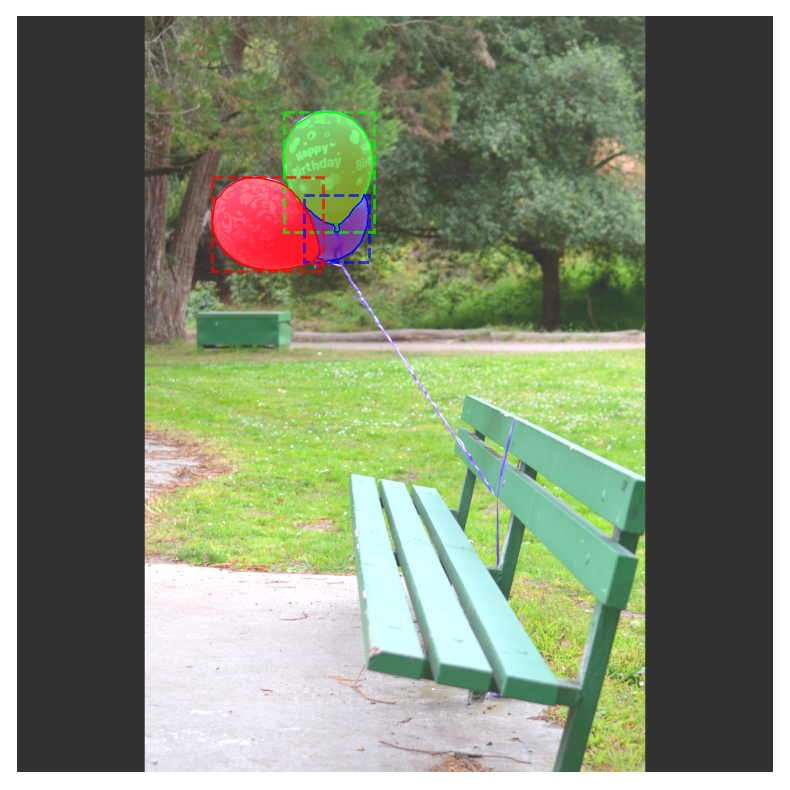

In [9]:
dataset = train_ds
USE_AUGS = True

# apply augmentation - uniform distribution
augmentations = [
    None, 
    imgaug.augmenters.AdditiveGaussianNoise(scale=0.2*255),
    imgaug.augmenters.Fliplr(),
    imgaug.augmenters.Add(50, per_channel=True),
    imgaug.augmenters.Sharpen(alpha=0.5),
]
augmentation = np.random.choice(augmentations) if USE_AUGS else None

image_id = np.random.choice(dataset.image_ids)
image, image_meta, gt_class_ids, gt_boxes, gt_masks = modellib.load_image_gt(dataset, config, image_id,
                                                                             augmentation=augmentation)

# loggins
print("image_id:", image_id)
print("augmentation:", augmentation)
log('image', image)
log('image_meta', image_meta)
log('gt_class_ids', gt_class_ids)
log('gt_boxes', gt_boxes)

# for more information on sample
meta = modellib.parse_image_meta(np.expand_dims(image_meta, axis=0))

# display
visualize.display_instances(image, 
                            gt_boxes,
                            gt_masks,
                            gt_class_ids, 
                            class_names=dataset.class_names,
                            captions=["" for _ in range(gt_boxes.shape[0])],
                            figsize=(10,10),)

## DataGenerator
Run the data generator used in training. Initialze the generator first:

In [11]:
augmentations = [
    imgaug.augmenters.AdditiveGaussianNoise(scale=0.2*255),
    imgaug.augmenters.Fliplr(),
    imgaug.augmenters.Add(50, per_channel=True),
    imgaug.augmenters.Sharpen(alpha=0.5),
]

dataset = val_ds
gen = modellib.DataGenerator(dataset, config, augmentations=None)

Iterate through samples:

Taken: 0.3693563938140869 sec
batch_images             shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10001  float32
batch_image_meta         shape: (1, 14)               min:    0.00000  max: 2048.00000  float64
batch_rpn_match          shape: (1, 261888, 1)        min:   -1.00000  max:    1.00000  int32
batch_rpn_bbox           shape: (1, 256, 4)           min:   -1.89161  max:    1.43631  float64
batch_gt_class_ids       shape: (1, 100)              min:    0.00000  max:    1.00000  int32
batch_gt_boxes           shape: (1, 100, 4)           min:    0.00000  max: 1010.00000  int32
batch_gt_masks           shape: (1, 1024, 1024, 100)  min:    0.00000  max:    1.00000  bool


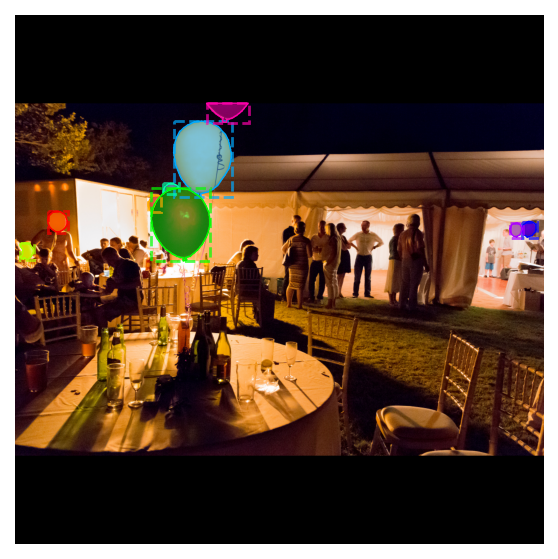

In [16]:
image_id = np.random.choice(dataset.image_ids)

# get a batch
start = time.time()
[batch_images, batch_image_meta, batch_rpn_match, batch_rpn_bbox, batch_gt_class_ids, 
 batch_gt_boxes, batch_gt_masks], outputs = gen[image_id]
print("Taken:", time.time()-start, "sec")

# unbatch
batch = 0
normalized_image = batch_images[batch]
gt_class_ids = batch_gt_class_ids[batch]
gt_bbox = batch_gt_boxes[batch]
gt_masks = batch_gt_masks[batch]

# filter fillers
idx = np.where(gt_class_ids)[0]
gt_class_ids = gt_class_ids[idx]
gt_bbox = gt_bbox[idx]
gt_masks = gt_masks[..., idx]

# denorm ground truth image
image = modellib.unmold_image(normalized_image, config)

# logging
log('batch_images', batch_images)
log('batch_image_meta', batch_image_meta)
log('batch_rpn_match', batch_rpn_match)
log('batch_rpn_bbox', batch_rpn_bbox)
log('batch_gt_class_ids', batch_gt_class_ids)
log('batch_gt_boxes', batch_gt_boxes)
log('batch_gt_masks', batch_gt_masks)
visualize.display_instances(image, 
                            gt_bbox,
                            gt_masks,
                            gt_class_ids, 
                            class_names=dataset.class_names,
                            captions=["" for _ in range(gt_class_ids.shape[0])],
                            figsize=(7,7),)